<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Run-sigma-sweep" data-toc-modified-id="Run-sigma-sweep-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Run sigma sweep</a></span></li><li><span><a href="#Plot-mean-success-vs-sigma" data-toc-modified-id="Plot-mean-success-vs-sigma-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Plot mean success vs sigma</a></span></li><li><span><a href="#Plot-persistent-time-vs-sigma" data-toc-modified-id="Plot-persistent-time-vs-sigma-1.2.0.3"><span class="toc-item-num">1.2.0.3&nbsp;&nbsp;</span>Plot persistent time vs sigma</a></span></li><li><span><a href="#Plot-std-vs-sigma" data-toc-modified-id="Plot-std-vs-sigma-1.2.0.4"><span class="toc-item-num">1.2.0.4&nbsp;&nbsp;</span>Plot std vs sigma</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Persistent-times-variability" data-toc-modified-id="Persistent-times-variability-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Persistent times variability</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#Systematic" data-toc-modified-id="Systematic-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Systematic</a></span></li></ul></li><li><span><a href="#Noise-trajectory" data-toc-modified-id="Noise-trajectory-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Noise trajectory</a></span></li><li><span><a href="#Combined-graphs" data-toc-modified-id="Combined-graphs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Combined graphs</a></span></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## General parameters

In [2]:
epsilon = 10e-80
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 2.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

#### Run sigma sweep

In [3]:
def run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=0.050):

    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
    tau_s = manager.nn.tau_s
    T_recall = T_persistence * manager.nn.minicolumns
    T_cue = 2 * tau_s
    nr = manager.canonical_network_representation
    n_patterns = len(nr)

    sigma_vector = np.linspace(0, sigma_max, num=sigma_number)

    successes_collection = np.zeros((sigma_number, samples))
    persistent_times_collection = {index: [] for index in range(sigma_number)}
    sequence_collection = {index: [] for index in range(sigma_number)}

    for index, sigma in enumerate(sigma_vector):
        manager.nn.sigma_out = sigma
        manager.nn.sigma_in = sigma * np.sqrt(2 / tau_s)
        for sample in range(samples):
            aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove,
                                              reset=True, empty_history=True)
            success, pattern_sequence, persistent_times, timings = aux
            successes_collection[index, sample] = success
            persistent_times_collection[index].append(persistent_times[:n_patterns])
            sequence_collection[index].append(pattern_sequence)

    results_dic = {'manager': manager, 'sigma_vector': sigma_vector, 'success': successes_collection,
                   'persistent times': persistent_times_collection, 'sequences': sequence_collection,
                   'T_persistence': T_persistence}

    return results_dic

#### Plot mean success vs sigma

In [4]:
def plot_mean_success_vs_sigma(results_dictionary, n_samples, index=0, label=0, ax=None, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')

    # Plot the mean
    ax.plot(sigma_vector, mean_success, 'o-', lw=lw, ms=ms, color=colors[index], label=label)
    
    if False:
        # Plot sigma05
        sigma09_arg = np.where(mean_success <= 0.9)[0]
        if sigma09_arg.size > 0:
            sigma09 = sigma_vector[sigma09_arg[0]]
            ax.plot(sigma09, 0.9, '*', ms=(ms + 20), color='black')

        sigma01_arg = np.where(mean_success <= 0.1)[0]
        if sigma01_arg.size > 0:
            sigma01 = sigma_vector[sigma01_arg[0]]
            ax.plot(sigma01, 0.1, '*', ms=(ms + 20), color='black')
    
    # Plot the interval
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sigma_vector, low, high, color=colors[index], alpha=alpha_graph)
    
    if add_zero_axis:
        ax.axhline(0, ls='--', color='gray')
        ax.axvline(0, ls='--', color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success rate')
    ax.legend(frameon=False)

    return ax

#### Plot persistent time vs sigma

In [49]:
def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None, single=True, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    low = np.zeros(sigma_vector.size)
    high = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)
        low[sigma_index] = np.percentile(flatted, 25)
        high[sigma_index] = np.percentile(flatted, 75)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    ax.fill_between(sigma_vector, low, high,color=colors[index], alpha=alpha_graph)
    if add_zero_axis:
        ax.axhline(0, ls='--',color='gray')
        ax.axvline(0, ls='--',color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{per, \sigma} \, (s)$')

    if single:
        ax.axhline(T_persistence, ls='--', color=colors[index], label=r'$T_{base}$' )
        ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
        ax.legend(frameon=False)
    
    return ax

#### Plot std vs sigma

In [6]:
def plot_std_time_vs_sigma(results_dictionary, index=0, label=0, ax=None, single=True):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)

    ax.plot(sigma_vector, std, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)

    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$\sigma_{T_{per}}$')

    if single:
        ax.legend(frameon=False)
    
    return ax

# Persistent times variability

## An example

In [7]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


sigma_number = 15
samples = 25
sigma_max = 2

results_dictionary_simple = run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)

CPU times: user 17.1 s, sys: 8 ms, total: 17.2 s
Wall time: 17.1 s


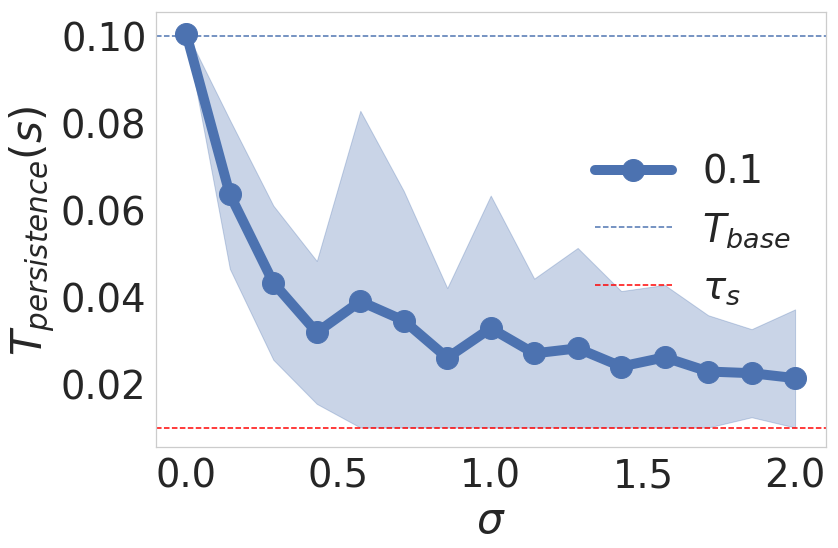

In [8]:
results_dictionary = results_dictionary_simple
label = str(T_persistence)
index = 0
ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=None)

## Systematic

In [9]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

Tp_list = [0.050, 0.100, 0.150]
results_dictionary_collection_tp = {}
sigma_number = 30
samples = 1000
sigma_max = 1.0

for T_persistence in Tp_list :
    results_dictionary= run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)  
    results_dictionary_collection_tp[T_persistence] = results_dictionary

CPU times: user 1h 3min 4s, sys: 1.08 s, total: 1h 3min 5s
Wall time: 1h 3min 6s


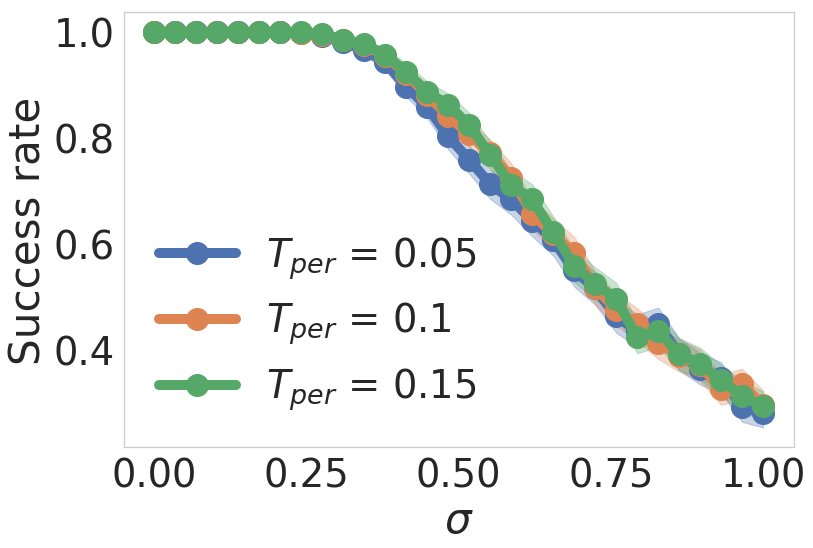

In [10]:
results_dictionary_collection = results_dictionary_collection_tp
ax = None
for index, Tp in enumerate(Tp_list):
    label = r'$T_{per}$ = ' + str(Tp)
    results_dictionary = results_dictionary_collection[Tp]
    ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=samples, index=index, label=label, ax=ax)

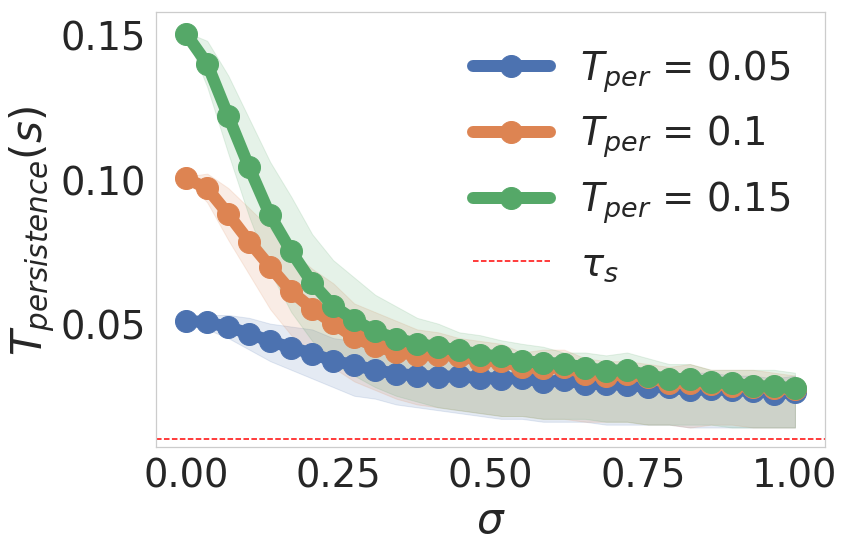

In [37]:
results_dictionary_collection = results_dictionary_collection_tp
ax = None
for index, Tp in enumerate(Tp_list):
    label = r'$T_{per}$ = ' + str(Tp)
    results_dictionary = results_dictionary_collection[Tp]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax, single=False)

ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
ax.legend(frameon=False)

In [32]:
np.percentile(flatted, 25)

0.014

In [33]:
np.percentile(flatted, 75)

0.033

(array([2272.,  502.,  133.,   45.,   26.,   10.,    6.,    2.,    0.,
           4.]),
 array([0.01  , 0.0338, 0.0576, 0.0814, 0.1052, 0.129 , 0.1528, 0.1766,
        0.2004, 0.2242, 0.248 ]),
 <a list of 10 Patch objects>)

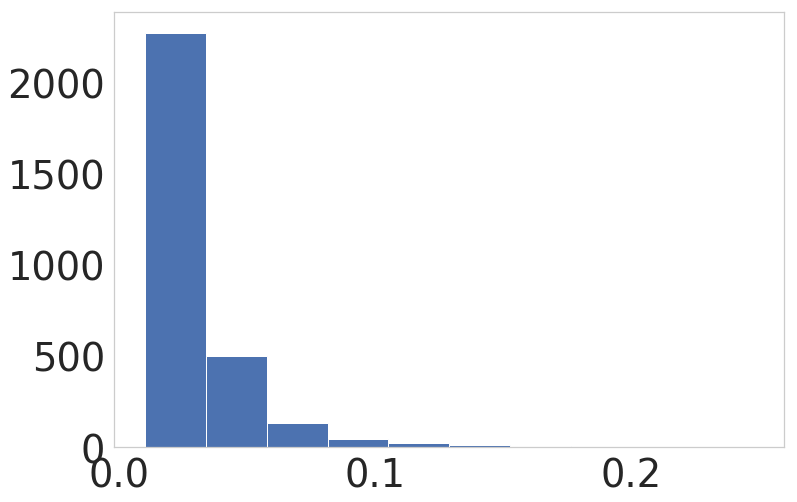

In [31]:
plt.hist(flatted)

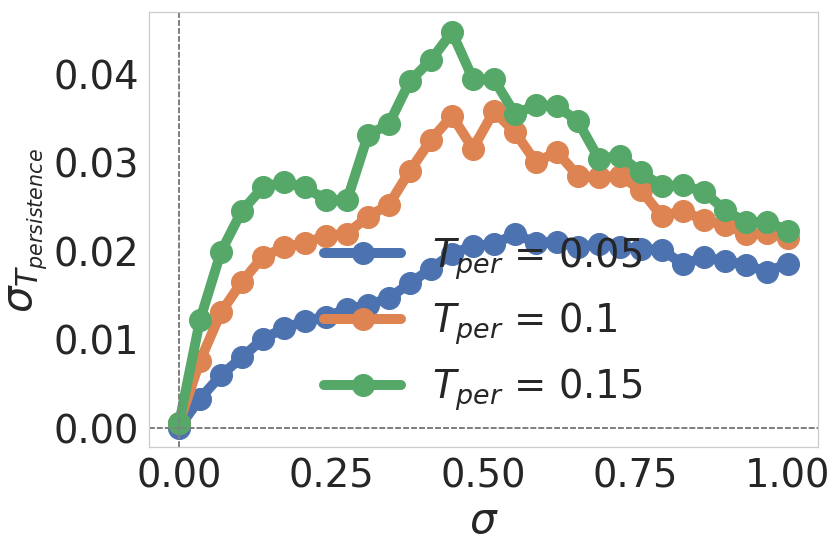

In [12]:
results_dictionary_collection = results_dictionary_collection_tp
ax = None
for index, Tp in enumerate(Tp_list):
    label = r'$T_{per}$ = ' + str(Tp)
    results_dictionary = results_dictionary_collection[Tp]
    ax = plot_std_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax, single=True)

#  Noise trajectory

In [13]:
n_trajectories = 80
indexes = [0, 1, 2, 3, 4]
sigma_out_trajectories = 0.05

In [14]:
%%time

strict_maximum = True

g_a = 1.0
g_I = 0.5
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 6
n_patterns = 6

# Training
ws = 1.0
wn =  0.2
wb = -20.0
alpha = 0.3

T_persistence = 0.200

# Manager properties
values_to_save = ['o', 's']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

nn.g_beta = 0.0

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb ,alpha=alpha)

T_recall = T_persistence * len(indexes)
T_cue = tau_s
I_cue = 0
nr = manager.canonical_network_representation

# Get the deterministic trajectories
manager.set_persistent_time_with_adaptation_gain(T_persistence)
manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=0, empty_history=True, reset=True)
determnistic_trajectories = {}
for index in indexes:
    determnistic_trajectories[index] = manager.history['s'][:, index]
    
# Get the noisy trajectories
manager.nn.sigma_in = sigma_out_trajectories * np.sqrt(2 / tau_s)
trajectories_dic = {index:[] for index in indexes}

for _ in range(n_trajectories):
    manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=0, empty_history=True, reset=True)
    for index in indexes:
        trajectories_dic[index].append(np.copy(manager.history['s'][:, index]))

CPU times: user 2.44 s, sys: 4 ms, total: 2.45 s
Wall time: 2.45 s


# Combined graphs

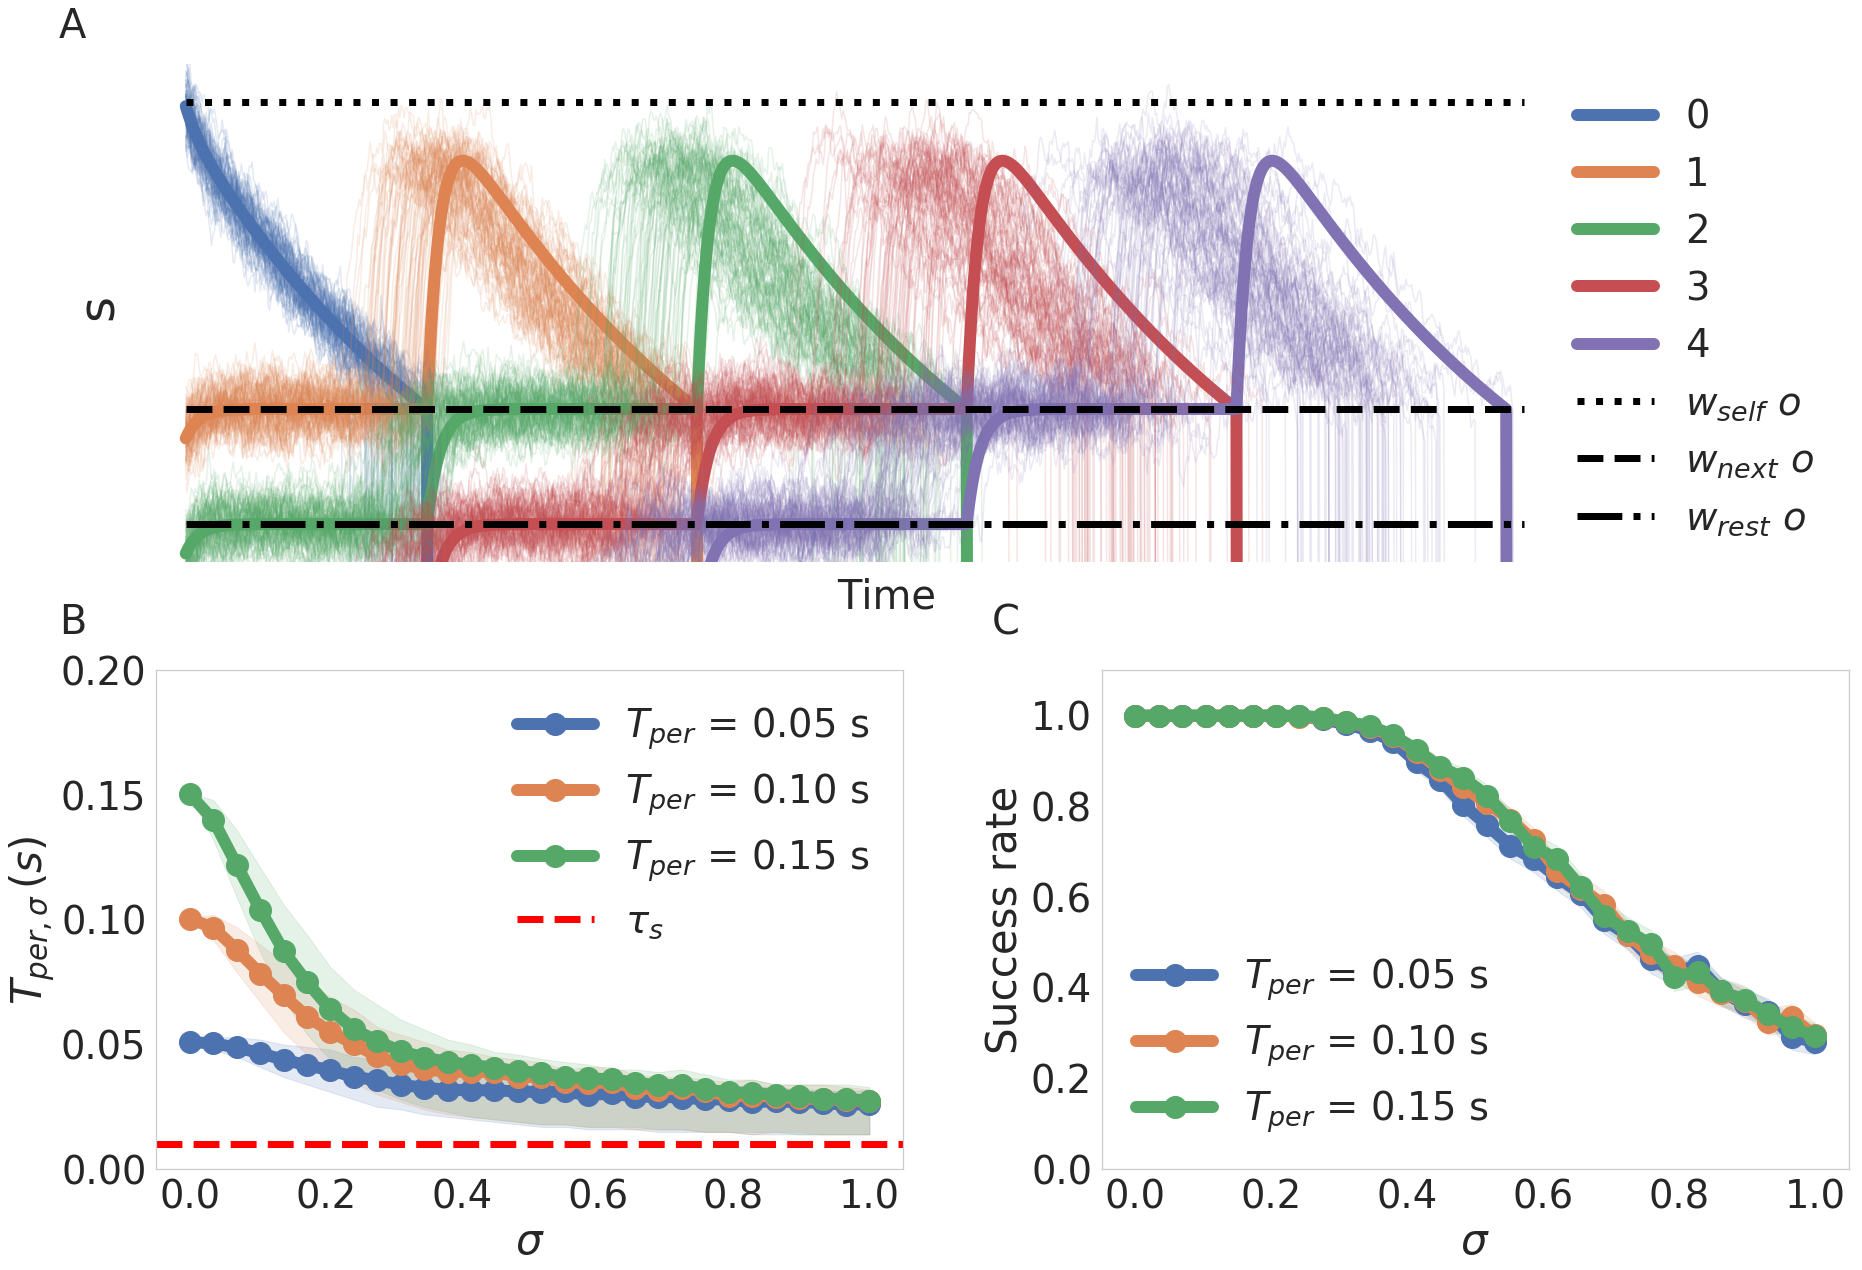

In [71]:
lw = 12
ms = 22
alpha_graph = 0.15
save = True
captions = True
add_zero_axis = False

start = 2.25 * tau_s
star_index = int(start / dt)
plot_time = manager.time[star_index:]

factor_scale = 1.5
s1 = int(18 * factor_scale)
s2 = int(12 * factor_scale)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(s1, s2))

################
# Noise trajectories
################

ax = fig.add_subplot(gs[0, :])
# Plot the deterministic trajectories
for index in indexes:
    s = determnistic_trajectories[index][star_index:]
    ax.plot(plot_time, s, lw=lw, color=colors[index], label=str(index))

# Plot the noise trajectories
for index in indexes:
    s_noise = trajectories_dic[index]
    for n_index in range(n_trajectories):
        s_instance = s_noise[n_index][star_index:]
        ax.plot(plot_time, s_instance, alpha=alpha_graph, color=colors[index])

# Plot the connectivity landmarks
if True:
    wr = wn - alpha
    ax.plot(plot_time, ws * np.ones(plot_time.size), ls=':', lw=lw - 5, color='black', label=r'$w_{self} \, \, o$')
    ax.plot(plot_time, wn * np.ones(plot_time.size), ls='--', lw=lw - 5, color='black', label=r'$w_{next} \, \, o$');
    ax.plot(plot_time, wr * np.ones(plot_time.size), ls='-.', lw=lw - 5, color='black', label=r'$w_{rest} \, \, o$')


ax.set_ylim([wr - 0.1, ws + 0.1])
ax.set_xlim([0, manager.time[-1] + 1.2 * T_persistence])
ax.legend(frameon=False, loc=1)
ax.text(x=-0.06, y=0.4, s='s', rotation=90, size=50)


#ax.arrow(0.2, 0, 0.6, 0.0, color='black', width=0.1)
ax.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)

if True:
    ax.axis('off')
        
################
# Sucess vs sigma
##################

results_dictionary_collection = results_dictionary_collection_tp
ax = fig.add_subplot(gs[1, 1])
for index, Tp in enumerate(Tp_list):
    label = r'$T_{per}$ = ' + f'{Tp:2.2f}' + ' s'
    results_dictionary = results_dictionary_collection[Tp]
    ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=samples, index=index, 
                                    label=label, ax=ax, add_zero_axis=add_zero_axis)

ax.set_ylim([0.0, 1.1])
############################
# Persistent time vs sigma
##########################
results_dictionary_collection = results_dictionary_collection_tp
ax = fig.add_subplot(gs[1, 0])
for index, Tp in enumerate(Tp_list):
    label = r'$T_{per}$ = ' + f'{Tp:2.2f}' + ' s'
    results_dictionary = results_dictionary_collection[Tp]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label,
                                       ax=ax, single=False, add_zero_axis=add_zero_axis)

ax.axhline(tau_s, ls='--', color='red', lw=lw - 5, label=r'$\tau_s$')
ax.legend(frameon=False)
ax.set_ylim([0.0, 0.200])

if captions:
    size = 40
    xpoint1 = 0.05
    xpoint2 = 0.53
    
    ypoint1 = 0.98
    ypoint2 = 0.52
    
    fig.text(xpoint1, ypoint1, 'A', size=size)
    
    fig.text(xpoint1, ypoint2, 'B', size=size)    
    fig.text(xpoint2, ypoint2, 'C', size=size)
    fig.text(0.45, ypoint2 + 0.02, 'Time', size=size)


fig.tight_layout()
    
if save:
    directory = '../plot_producers/'
    file_name = 'noise_diagram'
    format_string = '.pdf'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')